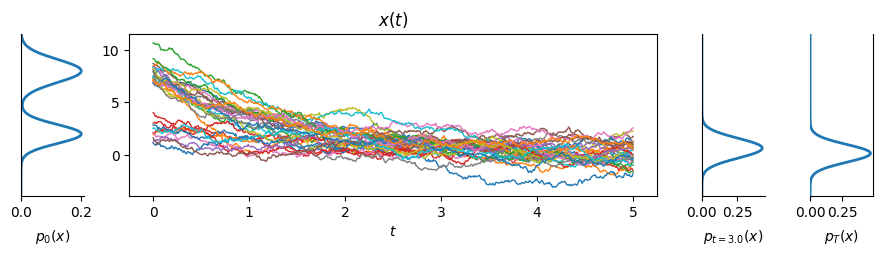

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Parameters (same as before)
beta = 0.7
sigma = 1.0
T = 5.0
t_target = 3.0
dt = 1e-2
steps = int(T/dt)

# GMM initial distribution
w = 0.55
mu1, s1 = 8.0, 1.1
mu2, s2 = 2.0, 0.9

K_traj = 32
N_part = 6000
rng = np.random.default_rng(1)

def sample_gmm(n, w, mu1, s1, mu2, s2, rng):
    u = rng.random(n)
    z1 = rng.normal(mu1, s1, size=n)
    z2 = rng.normal(mu2, s2, size=n)
    return np.where(u < w, z1, z2)

def gmm_pdf(y, w, mu1, s1, mu2, s2):
    n1 = (1.0/np.sqrt(2*np.pi*s1**2))*np.exp(-0.5*((y-mu1)/s1)**2)
    n2 = (1.0/np.sqrt(2*np.pi*s2**2))*np.exp(-0.5*((y-mu2)/s2)**2)
    return w*n1 + (1-w)*n2

def m_t(t, mu): return np.exp(-beta*t)*mu
def v_t(t, s): return np.exp(-2*beta*t)*s**2 + (sigma**2/(2*beta))*(1-np.exp(-2*beta*t))

def gmm_ou_pdf(y, t):
    m1, v1 = m_t(t, mu1), v_t(t, s1)
    m2, v2 = m_t(t, mu2), v_t(t, s2)
    n1 = (1.0/np.sqrt(2*np.pi*v1))*np.exp(-0.5*((y-m1)**2)/v1)
    n2 = (1.0/np.sqrt(2*np.pi*v2))*np.exp(-0.5*((y-m2)**2)/v2)
    return w*n1 + (1-w)*n2

# Forward OU simulation
x = sample_gmm(N_part, w, mu1, s1, mu2, s2, rng)
traj = x[:K_traj].copy()

times = [0.0]
traj_hist = [traj.copy()]
t = 0.0
for i in range(1, steps+1):
    dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
    x = x + (-beta*x)*dt + sigma*dW
    if i % int(steps/300) == 0:
        times.append(i*dt)
        traj_hist.append(x[:K_traj].copy())
    t += dt

times = np.array(times)
traj_hist = np.stack(traj_hist, axis=0)

# Figure with three side panels
fig = plt.figure(figsize=(11,2.1))
gs = GridSpec(nrows=1, ncols=4, width_ratios=[1.2, 10, 1.2, 1.2], wspace=0.25)
ax_left  = fig.add_subplot(gs[0,0])
ax_main  = fig.add_subplot(gs[0,1])
ax_mid   = fig.add_subplot(gs[0,2])
ax_right = fig.add_subplot(gs[0,3])

# Main trajectories
for j in range(traj_hist.shape[1]):
    ax_main.plot(times, traj_hist[:, j], linewidth=1)
ax_main.set_title("$x(t)$")
ax_main.set_xlabel("$t$")

ymin = np.min(traj_hist); ymax = np.max(traj_hist)
pad = 0.06*(ymax - ymin)
ylims = (ymin - pad, ymax + pad)
ax_main.set_ylim(*ylims)

ys = np.linspace(*ylims, 600)

# Left p0
ax_left.plot(gmm_pdf(ys, w, mu1, s1, mu2, s2), ys, color="C0", linewidth=2)
ax_left.set_ylim(*ylims); ax_left.set_xlim(left=0)
ax_left.set_yticks([]); ax_left.set_xlabel("$p_0(x)$", labelpad=6)
ax_left.spines["top"].set_visible(False); ax_left.spines["right"].set_visible(False)

# Middle pt (t=3)
ax_mid.plot(gmm_ou_pdf(ys, t_target), ys, color="C0", linewidth=2)
ax_mid.set_ylim(*ylims); ax_mid.set_xlim(left=0)
ax_mid.set_yticks([]); ax_mid.set_xlabel(f"$p_{{t={t_target}}}(x)$", labelpad=6)
ax_mid.spines["top"].set_visible(False); ax_mid.spines["right"].set_visible(False)

# Right pT
ax_right.plot(gmm_ou_pdf(ys, T), ys, color="C0", linewidth=2)
ax_right.set_ylim(*ylims); ax_right.set_xlim(left=0)
ax_right.set_yticks([]); ax_right.set_xlabel("$p_T(x)$", labelpad=6)
ax_right.yaxis.tick_right()
ax_right.spines["top"].set_visible(False); ax_right.spines["left"].set_visible(False)

plt.show()


---

## 完整版本

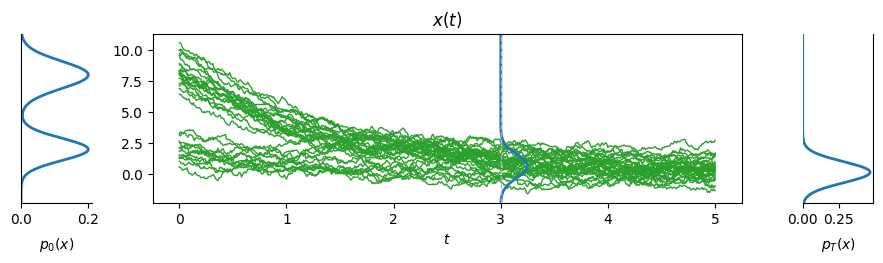

In [9]:
# Forward OU SDE with green trajectories and blue pdf curves (left, middle@t=3 overlay, right).
# No fill, no "violin" borders. Just single blue line curves like side panels.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---- Parameters ----
beta = 0.7
sigma = 1.0
T = 5.0
t_target = 3.0
dt = 1e-2
steps = int(T/dt)

# Initial GMM
w = 0.55
mu1, s1 = 8.0, 1.1
mu2, s2 = 2.0, 0.9

K_traj = 32
N_part = 6000
rng = np.random.default_rng(3)

def sample_gmm(n, w, mu1, s1, mu2, s2, rng):
    u = rng.random(n)
    z1 = rng.normal(mu1, s1, size=n)
    z2 = rng.normal(mu2, s2, size=n)
    return np.where(u < w, z1, z2)

def m_t(t, mu): return np.exp(-beta*t)*mu
def v_t(t, s): return np.exp(-2*beta*t)*s**2 + (sigma**2/(2*beta))*(1-np.exp(-2*beta*t))

def gmm_pdf(y, w, mu1, s1, mu2, s2):
    n1 = (1.0/np.sqrt(2*np.pi*s1**2))*np.exp(-0.5*((y-mu1)/s1)**2)
    n2 = (1.0/np.sqrt(2*np.pi*s2**2))*np.exp(-0.5*((y-mu2)/s2)**2)
    return w*n1 + (1-w)*n2

def gmm_ou_pdf(y, t):
    m1, v1 = m_t(t, mu1), v_t(t, s1)
    m2, v2 = m_t(t, mu2), v_t(t, s2)
    n1 = (1.0/np.sqrt(2*np.pi*v1))*np.exp(-0.5*((y-m1)**2)/v1)
    n2 = (1.0/np.sqrt(2*np.pi*v2))*np.exp(-0.5*((y-m2)**2)/v2)
    return w*n1 + (1-w)*n2

# ---- Forward OU simulation ----
x = sample_gmm(N_part, w, mu1, s1, mu2, s2, rng)
times = [0.0]; traj_hist = [x[:K_traj].copy()]
for i in range(1, steps+1):
    dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
    x = x + (-beta*x)*dt + sigma*dW
    if i % int(steps/300) == 0:
        times.append(i*dt)
        traj_hist.append(x[:K_traj].copy())
times = np.array(times)
traj_hist = np.stack(traj_hist, axis=0)

# ---- Figure with three blue pdf line panels and overlay on main ----
fig = plt.figure(figsize=(11,2.2))
gs = GridSpec(nrows=1, ncols=3, width_ratios=[1.2, 10, 1.2], wspace=0.25)
ax_left  = fig.add_subplot(gs[0,0])
ax_main  = fig.add_subplot(gs[0,1])
ax_right = fig.add_subplot(gs[0,2])

# main trajectories in green
for j in range(traj_hist.shape[1]):
    ax_main.plot(times, traj_hist[:, j], linewidth=1, color="tab:green")
ax_main.set_title("$x(t)$")
ax_main.set_xlabel("$t$")

# y-lims
ymin = np.min(traj_hist); ymax = np.max(traj_hist)
pad = 0.06*(ymax - ymin)
ylims = (ymin - pad, ymax + pad)
ax_main.set_ylim(*ylims)

ys = np.linspace(*ylims, 700)

# left p0 (blue line)
ax_left.plot(gmm_pdf(ys, w, mu1, s1, mu2, s2), ys, color="C0", linewidth=2)
ax_left.set_ylim(*ylims); ax_left.set_xlim(left=0)
ax_left.set_yticks([]); ax_left.set_xlabel("$p_0(x)$", labelpad=6)
ax_left.spines["top"].set_visible(False); ax_left.spines["right"].set_visible(False)

# right pT (blue line)
ax_right.plot(gmm_ou_pdf(ys, T), ys, color="C0", linewidth=2)
ax_right.set_ylim(*ylims); ax_right.set_xlim(left=0)
ax_right.set_yticks([]); ax_right.set_xlabel("$p_T(x)$", labelpad=6)
ax_right.yaxis.tick_right()
ax_right.spines["top"].set_visible(False); ax_right.spines["left"].set_visible(False)

# overlay p_t (blue line) directly on main panel at t=3
pdf_mid = gmm_ou_pdf(ys, t_target)
# scale pdf to a narrow horizontal extent; keep it single-sided like side panels
scale = 0.25  # width in "time" units for max pdf
pdf_mid_norm = pdf_mid / pdf_mid.max()
ax_main.plot(t_target + scale*pdf_mid_norm, ys, color="C0", linewidth=2)
# guide line at t=3 (optional faint gray)
ax_main.axvline(t_target, color="0.7", linestyle="--", linewidth=1)

plt.show()



---

### 有參考的畫圖

### ex1. Forward SDE (OU process)

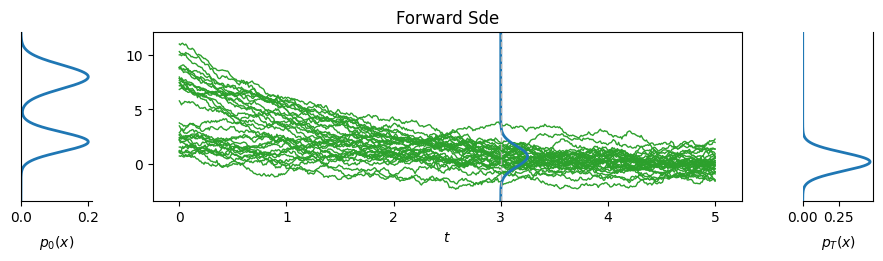

In [15]:
# Forward OU SDE from a 2-Gaussian mixture p0.
# Center: green trajectories; Left/Right: blue pdf lines p0, pT;
# Overlay: blue pdf line p_{t=3} directly on the main axis.
# No files saved.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# --- Parameters ---
beta = 0.7
sigma = 1.0
T = 5.0
t_target = 3.0
dt = 1e-2
steps = int(T/dt)

# GMM p0 = w*N(mu1,s1^2) + (1-w)*N(mu2,s2^2)
w = 0.55
mu1, s1 = 8.0, 1.1
mu2, s2 = 2.0, 0.9

K_traj = 32     # trajectories to show
N_part = 6000   # particles for better density snapshots
rng = np.random.default_rng(10)

# --- OU helpers ---
def m_t(t, mu): return np.exp(-beta*t)*mu
def v_t(t, s):  return np.exp(-2*beta*t)*s**2 + (sigma**2/(2*beta))*(1-np.exp(-2*beta*t))
def comp_pdf(x, m, v): return (1/np.sqrt(2*np.pi*v))*np.exp(-0.5*((x-m)**2)/v)

def gmm_pdf(y, w, mu1, s1, mu2, s2):
    n1 = comp_pdf(y, mu1, s1**2)
    n2 = comp_pdf(y, mu2, s2**2)
    return w*n1 + (1-w)*n2

def gmm_ou_pdf(y, t):
    m1, v1 = m_t(t, mu1), v_t(t, s1)
    m2, v2 = m_t(t, mu2), v_t(t, s2)
    return w*comp_pdf(y, m1, v1) + (1-w)*comp_pdf(y, m2, v2)

def sample_gmm(n):
    u = rng.random(n)
    z1 = rng.normal(mu1, s1, size=n)
    z2 = rng.normal(mu2, s2, size=n)
    return np.where(u < w, z1, z2)

# --- Forward SDE simulation (Euler–Maruyama) ---
x = sample_gmm(N_part)
times = [0.0]
traj_hist = [x[:K_traj].copy()]
t = 0.0
for i in range(1, steps+1):
    dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
    x = x + (-beta*x)*dt + sigma*dW
    t += dt
    if i % int(steps/300) == 0:
        times.append(t)
        traj_hist.append(x[:K_traj].copy())

times = np.array(times)
traj_hist = np.stack(traj_hist, axis=0)

# --- Build the panel figure ---
fig = plt.figure(figsize=(11,2.2))
gs = GridSpec(nrows=1, ncols=3, width_ratios=[1.2, 10, 1.2], wspace=0.25)
ax_left  = fig.add_subplot(gs[0,0])
ax_main  = fig.add_subplot(gs[0,1])
ax_right = fig.add_subplot(gs[0,2])

# Main: green trajectories
for j in range(traj_hist.shape[1]):
    ax_main.plot(times, traj_hist[:, j], color="tab:green", linewidth=1)
ax_main.set_title("Forward Sde")
ax_main.set_xlabel("$t$")

# y-limits based on percentiles to avoid outliers
y_all = traj_hist.reshape(-1)
lo, hi = np.percentile(y_all, [0, 100])
pad = 0.08*(hi - lo)
ax_main.set_ylim(lo - pad, hi + pad)
ys = np.linspace(ax_main.get_ylim()[0], ax_main.get_ylim()[1], 700)

# Left: p0 (blue line)
ax_left.plot(gmm_pdf(ys, w, mu1, s1, mu2, s2), ys, color="C0", linewidth=2)
ax_left.set_ylim(ax_main.get_ylim()); ax_left.set_xlim(left=0)
ax_left.set_yticks([]); ax_left.set_xlabel("$p_0(x)$", labelpad=6)
ax_left.spines["top"].set_visible(False); ax_left.spines["right"].set_visible(False)

# Right: pT (blue line)
ax_right.plot(gmm_ou_pdf(ys, T), ys, color="C0", linewidth=2)
ax_right.set_ylim(ax_main.get_ylim()); ax_right.set_xlim(left=0)
ax_right.set_yticks([]); ax_right.set_xlabel("$p_T(x)$", labelpad=6)
ax_right.yaxis.tick_right()
ax_right.spines["top"].set_visible(False); ax_right.spines["left"].set_visible(False)

# Overlay: p_{t=3} as a blue line directly on main axis (no fill)
pdf_mid = gmm_ou_pdf(ys, t_target)
pdf_mid = pdf_mid / pdf_mid.max()
scale = 0.25  # horizontal width in "time" units for the overlay
ax_main.plot(t_target + scale*pdf_mid, ys, color="C0", linewidth=2)
ax_main.axvline(t_target, color="0.7", linestyle="--", linewidth=1)

plt.show()


### Ex2. Backward SDE (OU process)

The right panel shows the initial sampling at X(t=T).

The left panel shows the results at X(t=0) and its maximum likelihood estimation (MLE).
MLE:
mean =  2.991860351387114
std  =  0.9840177943738078

Theoretical results
Theoretical mean =  3.0
Theoretical std  =  1.0


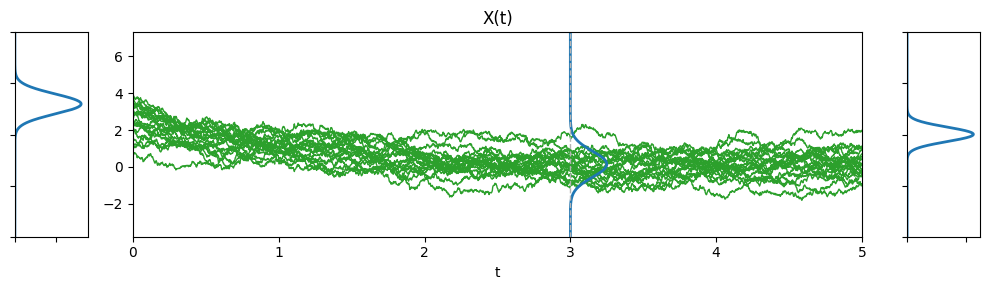

In [21]:
def OU_reverse(beta, sigma, mu_0, sigma_0, mean_T, sigma_T, T, N, M,
               t_target=3.0, overlay_width=0.25):                     # <<< ADDED: 參數

    dt = T/M
    time = np.linspace(0, T, M+1)

    # Euler-Maruyama method:
    Y_0 = np.zeros((N, M+1))

    # sample initial condition from N(mean_T, sigma_T^2) at t=T
    Y_0[:, M] = sigma_T*np.random.randn(N) + mean_T

    # ===== reverse iteration =====
    for ii in range(M):
        tk = (M-ii)*dt
        # Var(t), Mean(t) for OU (forward方向的解析式)：
        sigma_tk_square = np.exp(-2.0*beta*tk)*(sigma_0**2) + (1-np.exp(-2.0*beta*tk))*(sigma**2)/(2.0*beta)
        mt = np.exp(-beta*tk)*mu_0
        # single-Gaussian score
        score = -(Y_0[:, M-ii] - mt)/sigma_tk_square
        # reverse SDE drift: f - g^2 * score
        Y_0[:, M-ii-1] = Y_0[:, M-ii] + (-dt)*( -beta*Y_0[:, M-ii] - (sigma**2)*score)
        # diffusion term
        Y_0[:, M-ii-1] = Y_0[:, M-ii-1] + sigma*np.sqrt(dt)*np.random.randn(N)

    # ===== statistics at t=0 =====
    mean_0 = np.mean(Y_0[:, 0])
    std_0 = np.std(Y_0[:, 0])

    # ===== pdf curves (left/right/overlay) =====
    y = np.linspace(-10, 10, 600)

    # at t=0 (用 MLE 畫線；你要用理論 mu_0, sigma_0 也可)
    height_0 = 1.0/(std_0*np.sqrt(2.0*np.pi))
    pdf_0 = np.exp(-0.5*((y - mean_0)/std_0)**2) * height_0          # <<< CHANGED

    # at t=T（用給定的 mean_T, sigma_T）
    height_M = 1.0/(sigma_T*np.sqrt(2.0*np.pi))
    pdf_M = np.exp(-0.5*((y - mean_T)/sigma_T)**2) * height_M        # <<< CHANGED

    # at t=t_target（解析 OU：mean/var 由 mu_0, sigma_0 推到 t_target）
    var_t = np.exp(-2.0*beta*t_target)*(sigma_0**2) + (1-np.exp(-2.0*beta*t_target))*(sigma**2)/(2.0*beta)  # <<< ADDED
    mean_t = np.exp(-beta*t_target)*mu_0                                                                    # <<< ADDED
    std_t = np.sqrt(var_t)                                                                                  # <<< ADDED
    height_t = 1.0/(std_t*np.sqrt(2.0*np.pi))                                                               # <<< ADDED
    pdf_t = np.exp(-0.5*((y - mean_t)/std_t)**2) * height_t                                                 # <<< ADDED
    pdf_t = pdf_t / np.max(pdf_t)                                                                           # <<< ADDED: overlay 正規化到 [0,1]

    # ===== print info =====
    print('The right panel shows the initial sampling at X(t=T).')
    print('')
    print('The left panel shows the results at X(t=0) and its maximum likelihood estimation (MLE).')
    print('MLE:')
    print('mean = ', mean_0)
    print('std  = ', std_0)
    print('')
    print('Theoretical results')
    print('Theoretical mean = ', mu_0)
    print('Theoretical std  = ', sigma_0)

    # ===== figure with side pdfs + main trajectories + overlay p_t =====
    f, (a2, a0, a1) = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 10, 1]})

    # --- main: trajectories（統一綠色） ---
    from random import sample as _sample
    for ii in _sample(range(N), min(20, N)):                           # <<< CHANGED: 只畫 20 條
        a0.plot(time, Y_0[ii, :], color='tab:green', linewidth=1)      # <<< CHANGED
    # （移除挑最大/最小再畫一次，避免顏色不一致）                         # <<< CHANGED

    # --- overlay p_t at t_target on main（藍色線，無填色） ---
    a0.plot(t_target + overlay_width*pdf_t, y, color='C0', linewidth=2)  # <<< ADDED
    a0.axvline(t_target, color='0.7', linestyle='--', linewidth=1)       # <<< ADDED（輔助線）

    # --- left: p0 (藍色線，不再 scatter) ---
    a2.plot(pdf_0, y, color='C0', linewidth=2)                           # <<< CHANGED
    a2.set_xlim(0, max(pdf_0)*1.1)                                       # <<< CHANGED
    a2.set_ylim(-10, 10)
    a2.set_xticklabels([])
    a2.set_yticklabels([])

    # --- main: axes style ---
    a0.set_xlim(0, T)
    # 更保守的 y 範圍，避免被截到；你也可改成依據百分位數                     # <<< CHANGED
    y_all = Y_0  # (N, M+1)
    lo, hi = np.percentile(y_all, [0, 100])
    pad = 0.08*(hi - lo)
    a0.set_ylim(lo - pad, hi + pad)
    a0.set(xlabel='t')
    a0.set(title='X(t)')

    # --- right: pT (藍色線，不再 scatter) ---
    a1.plot(pdf_M, y, color='C0', linewidth=2)                           # <<< CHANGED
    a1.set_xlim(0, max(pdf_M)*1.1)                                       # <<< CHANGED
    a1.set_ylim(-10, 10)
    a1.set_xticklabels([])
    a1.set_yticklabels([])

    f.tight_layout()
    plt.show()

OU_reverse(beta=1.0, sigma=1.0,
            mu_0=3.0, sigma_0=1.0,
            mean_T=0.02, sigma_T=0.707,
            T=5.0, N=2000, M=2000)


---

## 這邊是完成的 但reverse有點兩光

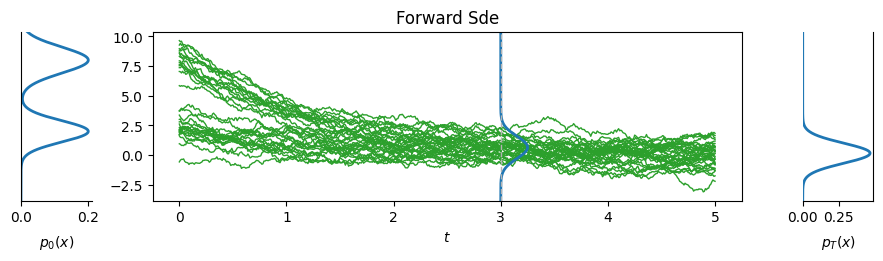

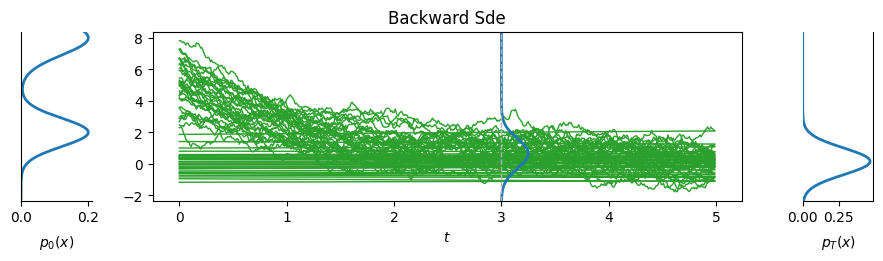

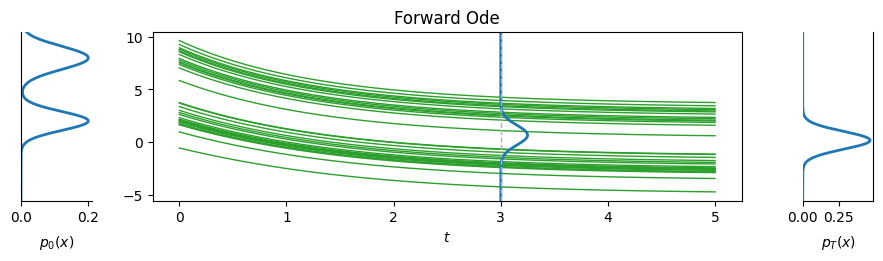

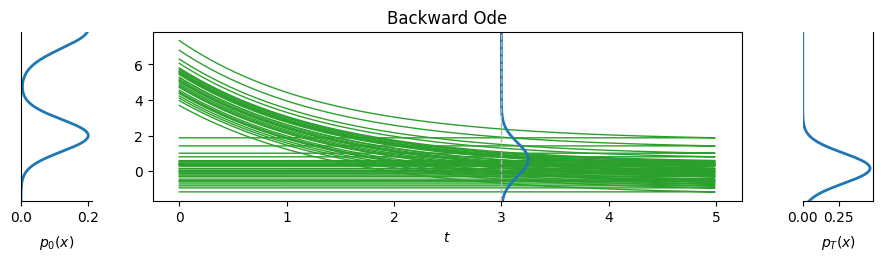

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_OU_panel(mode="forward_sde",
                  beta=0.7, sigma=1.0,
                  T=5.0, t_target=3.0, dt=1e-2,
                  w=0.55, mu1=8.0, s1=1.1, mu2=2.0, s2=0.9,
                  K_traj=32, N_part=6000, seed=0):
    rng = np.random.default_rng(seed)

    def sample_gmm(n, w, mu1, s1, mu2, s2, rng):
        u = rng.random(n)
        z1 = rng.normal(mu1, s1, size=n)
        z2 = rng.normal(mu2, s2, size=n)
        return np.where(u < w, z1, z2)

    def m_t(t, mu): return np.exp(-beta*t)*mu
    def v_t(t, s): return np.exp(-2*beta*t)*s**2 + (sigma**2/(2*beta))*(1-np.exp(-2*beta*t))
    def gmm_pdf(y, w, mu1, s1, mu2, s2):
        n1 = (1.0/np.sqrt(2*np.pi*s1**2))*np.exp(-0.5*((y-mu1)/s1)**2)
        n2 = (1.0/np.sqrt(2*np.pi*s2**2))*np.exp(-0.5*((y-mu2)/s2)**2)
        return w*n1 + (1-w)*n2
    def gmm_ou_pdf(y, t):
        m1, v1 = m_t(t, mu1), v_t(t, s1)
        m2, v2 = m_t(t, mu2), v_t(t, s2)
        n1 = (1.0/np.sqrt(2*np.pi*v1))*np.exp(-0.5*((y-m1)**2)/v1)
        n2 = (1.0/np.sqrt(2*np.pi*v2))*np.exp(-0.5*((y-m2)**2)/v2)
        return w*n1 + (1-w)*n2

    steps = int(T/dt)

    # ---- initialization ----
    if "forward" in mode:
        x = sample_gmm(N_part, w, mu1, s1, mu2, s2, rng)
    else:
        m1_T, v1_T = m_t(T, mu1), v_t(T, s1)
        m2_T, v2_T = m_t(T, mu2), v_t(T, s2)
        x1 = rng.normal(m1_T, np.sqrt(v1_T), size=N_part)
        x2 = rng.normal(m2_T, np.sqrt(v2_T), size=N_part)
        u = rng.random(N_part)
        x = np.where(u < w, x1, x2)

    # ---- simulate ----
    times = [0.0]; traj_hist = [x[:K_traj].copy()]
    t = 0.0 if "forward" in mode else T
    sign = 1.0 if "forward" in mode else -1.0

    for i in range(1, steps+1):
        if "sde" in mode:
            dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
            if "forward" in mode:
                x = x + (-beta*x)*dt + sigma*dW
            else:  # backward SDE
                m1_t, v1_t = m_t(t, mu1), v_t(t, s1)
                m2_t, v2_t = m_t(t, mu2), v_t(t, s2)
                mt = w*m1_t + (1-w)*m2_t
                vt = w*v1_t + (1-w)*v2_t
                drift = (-beta*x + (sigma**2)*(x - mt)/vt)
                x = x + drift*(-dt) + sigma*dW
        else:
            m1_t, v1_t = m_t(t, mu1), v_t(t, s1)
            m2_t, v2_t = m_t(t, mu2), v_t(t, s2)
            mt = w*m1_t + (1-w)*m2_t
            vt = w*v1_t + (1-w)*v2_t
            drift = (-beta*x + (sigma**2/2.0)*(x - mt)/vt)
            x = x + drift*(sign*dt)
        t += sign*dt

        if i % int(steps/300) == 0:
            current_t = i*dt if "forward" in mode else T - i*dt
            times.append(current_t)
            traj_hist.append(x[:K_traj].copy())

    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)
    if "backward" in mode:
        times = times[::-1]
        traj_hist = traj_hist[::-1, :]

    # ---- plotting ----
    fig = plt.figure(figsize=(11,2.2))
    gs = GridSpec(nrows=1, ncols=3, width_ratios=[1.2, 10, 1.2], wspace=0.25)
    ax_left  = fig.add_subplot(gs[0,0])
    ax_main  = fig.add_subplot(gs[0,1])
    ax_right = fig.add_subplot(gs[0,2])

    for j in range(traj_hist.shape[1]):
        ax_main.plot(times, traj_hist[:, j], linewidth=1, color="tab:green")
    ax_main.set_title(mode.replace("_", " ").title())
    ax_main.set_xlabel("$t$")

    ymin = np.min(traj_hist); ymax = np.max(traj_hist)
    pad = 0.06*(ymax - ymin)
    ylims = (ymin - pad, ymax + pad)
    ax_main.set_ylim(*ylims)
    ys = np.linspace(*ylims, 700)

    ax_left.plot(gmm_pdf(ys, w, mu1, s1, mu2, s2), ys, color="C0", linewidth=2)
    ax_left.set_ylim(*ylims); ax_left.set_xlim(left=0)
    ax_left.set_yticks([]); ax_left.set_xlabel("$p_0(x)$", labelpad=6)
    ax_left.spines["top"].set_visible(False); ax_left.spines["right"].set_visible(False)

    ax_right.plot(gmm_ou_pdf(ys, T), ys, color="C0", linewidth=2)
    ax_right.set_ylim(*ylims); ax_right.set_xlim(left=0)
    ax_right.set_yticks([]); ax_right.set_xlabel("$p_T(x)$", labelpad=6)
    ax_right.yaxis.tick_right()
    ax_right.spines["top"].set_visible(False); ax_right.spines["left"].set_visible(False)

    pdf_mid = gmm_ou_pdf(ys, t_target)
    scale = 0.25
    pdf_mid_norm = pdf_mid / pdf_mid.max()
    ax_main.plot(t_target + scale*pdf_mid_norm, ys, color="C0", linewidth=2)
    ax_main.axvline(t_target, color="0.7", linestyle="--", linewidth=1)
    plt.show()

plot_OU_panel("forward_sde")
plot_OU_panel("backward_sde")
plot_OU_panel("forward_ode")
plot_OU_panel("backward_ode")





---

# 試圖修改 backward SDE的水平怪異現象

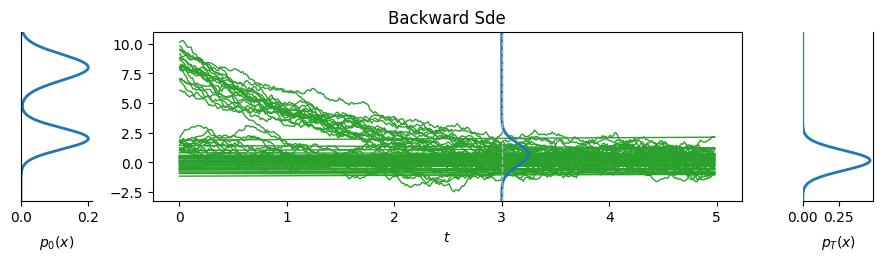

In [12]:
# Fix for backward SDE: you must use the TRUE score of the OU-evolved Gaussian mixture,
# not the moment-averaged mean/variance. Implement responsibilities r_k and score, then use
# drift = f - g^2 * score (and ODE uses f - (g^2/2)*score).

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_OU_panel_fixed(mode="backward_sde",
                        beta=0.7, sigma=1.0,
                        T=5.0, t_target=3.0, dt=5e-3,
                        w=0.55, mu1=8.0, s1=1.1, mu2=2.0, s2=0.9,
                        K_traj=32, N_part=6000, seed=0):
    rng = np.random.default_rng(seed)

    def sample_gmm(n, w, mu1, s1, mu2, s2, rng):
        u = rng.random(n)
        z1 = rng.normal(mu1, s1, size=n)
        z2 = rng.normal(mu2, s2, size=n)
        return np.where(u < w, z1, z2)

    def m_t(t, mu): return np.exp(-beta*t)*mu
    def v_t(t, s): return np.exp(-2*beta*t)*s**2 + (sigma**2/(2*beta))*(1-np.exp(-2*beta*t))

    def comp_pdf(x, m, v):
        return (1.0/np.sqrt(2*np.pi*v))*np.exp(-0.5*((x-m)**2)/v)

    def gmm_pdf(y, w, mu1, s1, mu2, s2):
        n1 = comp_pdf(y, mu1, s1**2)
        n2 = comp_pdf(y, mu2, s2**2)
        return w*n1 + (1-w)*n2

    def gmm_ou_pdf(y, t):
        m1, v1 = m_t(t, mu1), v_t(t, s1)
        m2, v2 = m_t(t, mu2), v_t(t, s2)
        n1 = comp_pdf(y, m1, v1)
        n2 = comp_pdf(y, m2, v2)
        return w*n1 + (1-w)*n2

    def gmm_ou_score(x, t):
        """True score ∇_x log p_t(x) of the OU-evolved 2-Gaussian mixture."""
        m1, v1 = m_t(t, mu1), v_t(t, s1)
        m2, v2 = m_t(t, mu2), v_t(t, s2)
        n1 = comp_pdf(x, m1, v1)
        n2 = comp_pdf(x, m2, v2)
        denom = w*n1 + (1-w)*n2 + 1e-12
        # component scores
        s1x = -(x - m1)/v1
        s2x = -(x - m2)/v2
        # responsibilities
        r1 = (w*n1)/denom
        r2 = 1.0 - r1
        return r1*s1x + r2*s2x

    steps = int(T/dt)

    # init
    if "forward" in mode:
        x = sample_gmm(N_part, w, mu1, s1, mu2, s2, rng)
    else:
        m1_T, v1_T = m_t(T, mu1), v_t(T, s1)
        m2_T, v2_T = m_t(T, mu2), v_t(T, s2)
        x1 = rng.normal(m1_T, np.sqrt(v1_T), size=N_part)
        x2 = rng.normal(m2_T, np.sqrt(v2_T), size=N_part)
        u = rng.random(N_part)
        x = np.where(u < w, x1, x2)

    times = [0.0]; traj_hist = [x[:K_traj].copy()]
    t = 0.0 if "forward" in mode else T
    sign = 1.0 if "forward" in mode else -1.0

    for i in range(1, steps+1):
        if "sde" in mode:
            dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
            if "forward" in mode:
                x = x + (-beta*x)*dt + sigma*dW
            else:
                s = gmm_ou_score(x, t)          # TRUE score
                drift = (-beta*x) - (sigma**2)*s # f - g^2 * score
                x = x + drift*(-dt) + sigma*dW
        else:
            s = gmm_ou_score(x, t)
            drift = (-beta*x) - (sigma**2/2.0)*s
            x = x + drift*(sign*dt)
        t += sign*dt

        if i % int(steps/300) == 0:
            current_t = i*dt if "forward" in mode else T - i*dt
            times.append(current_t)
            traj_hist.append(x[:K_traj].copy())

    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)
    if "backward" in mode:
        times = times[::-1]
        traj_hist = traj_hist[::-1, :]

    # plotting
    fig = plt.figure(figsize=(11,2.2))
    gs = GridSpec(nrows=1, ncols=3, width_ratios=[1.2,10,1.2], wspace=0.25)
    ax_left = fig.add_subplot(gs[0,0])
    ax_main = fig.add_subplot(gs[0,1])
    ax_right= fig.add_subplot(gs[0,2])

    for j in range(traj_hist.shape[1]):
        ax_main.plot(times, traj_hist[:, j], linewidth=1, color="tab:green")
    ax_main.set_title(mode.replace("_"," ").title())
    ax_main.set_xlabel("$t$")

    ymin, ymax = np.min(traj_hist), np.max(traj_hist)
    pad = 0.06*(ymax - ymin)
    ylims = (ymin - pad, ymax + pad)
    ax_main.set_ylim(*ylims)
    ys = np.linspace(*ylims, 700)

    ax_left.plot(gmm_pdf(ys, w, mu1, s1, mu2, s2), ys, color="C0", linewidth=2)
    ax_left.set_ylim(*ylims); ax_left.set_xlim(left=0)
    ax_left.set_yticks([]); ax_left.set_xlabel("$p_0(x)$", labelpad=6)
    ax_left.spines["top"].set_visible(False); ax_left.spines["right"].set_visible(False)

    ax_right.plot(gmm_ou_pdf(ys, T), ys, color="C0", linewidth=2)
    ax_right.set_ylim(*ylims); ax_right.set_xlim(left=0)
    ax_right.set_yticks([]); ax_right.set_xlabel("$p_T(x)$", labelpad=6)
    ax_right.yaxis.tick_right()
    ax_right.spines["top"].set_visible(False); ax_right.spines["left"].set_visible(False)

    pdf_mid = gmm_ou_pdf(ys, t_target)
    pdf_mid_norm = pdf_mid / pdf_mid.max()
    ax_main.plot(t_target + 0.25*pdf_mid_norm, ys, color="C0", linewidth=2)
    ax_main.axvline(t_target, color="0.7", linestyle="--", linewidth=1)

    plt.show()

# Show the fixed Backward SDE
plot_OU_panel_fixed("backward_sde")
